In [55]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.cluster import KMeans
from collections import Counter
import itertools

plt.style.use('fivethirtyeight')

# 1. Data Processing & Cleaning 

In [56]:
df = pd.read_csv("ds_mulakat.csv")
df.head(10)

/var/folders/fm/4vfl29px4_15c1dns3s89nk80000gn/T/ipykernel_963/2549424855.py:1: DtypeWarning: Columns (102,116) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("ds_mulakat.csv")


,sync_name,source_address,destination_address,source_port,destination_port,protocol,app_protocol,application_name,application_category_name,master_application_name,...,dst_asn,nbns_conflict_count,ndr_name,source_type,destination_type,session_id,session_id_from_time,protocol_name,source_asset_type,destination_asset_type
0,master-node,192.168.2.100,192.168.0.1,0,0,0,1000,ARP-Request,ARP,ARP,...,"{''AsnCode'': 0, ''AsnOrganizationName'': ''''}",0,NaN,INTERNAL,INTERNAL,32322361323232235521000,17107708357650563232236132323223552100,ARP,NaN,NaN
1,master-node,10.10.10.140,10.10.10.1,0,0,0,1000,ARP-Request,ARP,ARP,...,"{''AsnCode'': 0, ''AsnOrganizationName'': ''''}",0,NaN,INTERNAL,INTERNAL,168430220168430081000,171077083595588916843022016843008100,ARP,NaN,NaN
2,master-node,10.10.92.254,10.10.92.22,0,0,0,1000,ARP-Reply,ARP,ARP,...,"{''AsnCode'': 0, ''AsnOrganizationName'': ''''}",0,NaN,INTERNAL,INTERNAL,168451326168451094000,171077083635939516845132616845109400,ARP,NaN,NaN
3,master-node,10.1.66.11,10.1.66.12,0,0,0,1000,ARP-Request,ARP,ARP,...,"{''AsnCode'': 0, ''AsnOrganizationName'': ''''}",0,NaN,INTERNAL,INTERNAL,167854604167854603000,171077083776451916785460416785460300,ARP,NaN,NaN
4,master-node,10.10.107.254,10.10.107.11,0,0,0,1000,ARP-Reply,ARP,ARP,...,"{''AsnCode'': 0, ''AsnOrganizationName'': ''''}",0,NaN,INTERNAL,INTERNAL,168455166168454923000,171077083802287716845516616845492300,ARP,NaN,NaN
5,master-node,192.168.10.2,192.168.10.1,0,0,0,1000,ARP-Request,ARP,ARP,...,"{''AsnCode'': 0, ''AsnOrganizationName'': ''''}",0,NaN,INTERNAL,INTERNAL,32322380823232238081000,17107708395847563232238082323223808100,ARP,NaN,NaN
6,master-node,10.1.44.102,10.1.44.100,0,0,0,1000,ARP-Request,ARP,ARP,...,"{''AsnCode'': 0, ''AsnOrganizationName'': ''''}",0,NaN,INTERNAL,INTERNAL,167849062167849060000,171077083993365916784906216784906000,ARP,NaN,NaN
7,master-node,10.1.44.102,10.1.44.100,0,0,0,1000,ARP-Reply,ARP,ARP,...,"{''AsnCode'': 0, ''AsnOrganizationName'': ''''}",0,NaN,INTERNAL,INTERNAL,167849062167849060000,171077084020593716784906216784906000,ARP,NaN,NaN
8,master-node,10.10.10.150,10.10.10.1,0,0,0,1000,ARP-Request,ARP,ARP,...,"{''AsnCode'': 0, ''AsnOrganizationName'': ''''}",0,NaN,INTERNAL,INTERNAL,168430230168430081000,171077084163299116843023016843008100,ARP,NaN,NaN
9,master-node,192.168.101.10,192.168.100.1,0,0,0,1000,ARP-Request,ARP,ARP,...,"{''AsnCode'': 0, ''AsnOrganizationName'': ''''}",0,NaN,INTERNAL,INTERNAL,32322613863232261121000,17107708427269423232261386323226112100,ARP,NaN,NaN


In [57]:
def cluster(df, col_name):
    """
    k-Means applied for Clustering, try k-Medeoids too!!
    """
    assert type(col_name) == str 
    cluster_mapping = {0: "low", 1: "high", 
                       2: "normal", 3:"extreme"}
    col = np.array(df[col_name]).reshape(-1, 1)
   
    kmeans = KMeans(n_clusters=4, random_state=0, init='k-means++', n_init="auto").fit(col)
    
    df['cluster'] = kmeans.labels_
    df['cluster'] = df['cluster'].map(cluster_mapping)
    label_counts = df['cluster'].value_counts()
    print("Cluster Label Counts:")
    print(label_counts,"\n")
    print("Cluster Centers: ")
    print(kmeans.cluster_centers_)
    return df

**Fields to be used:**
+ *sync_name:*  The device which collected the mirrored data. (All master-node)
+ *source_address:* Source IP address of the connection.
+ *destination_address:* Destination IP address of the connection.
+ *source_port:* Source port value of the connection.
+ *destination_port:* Destination port value of the connection.
+ *source_type:* "Type of source. (INTERNAL, EXTERNAL)"
+ *destination_type:* "Type of destination. (INTERNAL, EXTERNAL)"
+ *package_count:* Seen packet count in bidirectional traffic. (Data volume)
+ *bidirectional_bytes:* Bidirectional seen bytes sum. (Data volume)
+ *src2dst_bytes:* Source->Destination seen bytes sum. (upload)
+ *dst2src_bytes:* Destination->Source seen bytes sum. (download)
+ *protocol_name:* Network layer's protocol name.
+ *event_time:* Time value when the session collected.
+ *login_fail_count:* Sets to 1 if a login fail detected.
+ *session_id:* Calculated session ID with five tuple (src_ip, dst_ip, src_port, dst_port, protocol).
+ *protocol:* Network layer protocol's numeric equivalent used in the connection.
+ *app_protocol:* Application layer protocol's numeric equivalent used in the connection.
+ *application_name:* Application layer protocol's name used in the connection.
+ *application_category_name:* Application layer protocol's used in the connection.

In [58]:
cols_to_keep = [
                "source_address","destination_address","source_port","destination_port","source_type",
                "destination_type","package_count","bidirectional_bytes","src2dst_bytes","dst2src_bytes",
                "protocol_name", "event_time","login_fail_count","session_id","protocol","app_protocol",
                "application_name","application_category_name","master_application_name"
                ]
df = df[cols_to_keep]
df

,source_address,destination_address,source_port,destination_port,source_type,destination_type,package_count,bidirectional_bytes,src2dst_bytes,dst2src_bytes,protocol_name,event_time,login_fail_count,session_id,protocol,app_protocol,application_name,application_category_name,master_application_name
0,192.168.2.100,192.168.0.1,0,0,INTERNAL,INTERNAL,1,0,0,0,ARP,2024-03-18T14:07:19.738372034Z,0,32322361323232235521000,0,1000,ARP-Request,ARP,ARP
1,10.10.10.140,10.10.10.1,0,0,INTERNAL,INTERNAL,1,0,0,0,ARP,2024-03-18T14:07:19.738420516Z,0,168430220168430081000,0,1000,ARP-Request,ARP,ARP
2,10.10.92.254,10.10.92.22,0,0,INTERNAL,INTERNAL,1,0,0,0,ARP,2024-03-18T14:07:19.738504769Z,0,168451326168451094000,0,1000,ARP-Reply,ARP,ARP
3,10.1.66.11,10.1.66.12,0,0,INTERNAL,INTERNAL,1,0,0,0,ARP,2024-03-18T14:07:19.738760638Z,0,167854604167854603000,0,1000,ARP-Request,ARP,ARP
4,10.10.107.254,10.10.107.11,0,0,INTERNAL,INTERNAL,1,0,0,0,ARP,2024-03-18T14:07:19.738807908Z,0,168455166168454923000,0,1000,ARP-Reply,ARP,ARP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160978,10.10.100.100,1.1.1.1,62255,53,INTERNAL,EXTERNAL,8,1085,240,845,UDP,2024-03-18T14:32:28.54536553Z,0,16845322016843009536225517,17,219,DNS.Microsoft365,DNS,DNS
160979,10.10.100.100,1.1.1.1,56538,53,INTERNAL,EXTERNAL,6,611,148,463,UDP,2024-03-18T14:32:26.897434089Z,0,16845322016843009535653817,17,5,DNS,DNS,Unknown
160980,10.110.10.42,10.10.100.100,0,0,INTERNAL,INTERNAL,4,690,690,0,ICMP,2024-03-18T14:33:13.194239499Z,0,174983722168453220001,1,81,ICMP,Network,Unknown
160981,10.10.100.100,1.1.1.1,56642,53,INTERNAL,EXTERNAL,12,1100,397,703,UDP,2024-03-18T14:34:12.306567069Z,0,16845322016843009535664217,17,276,DNS.Azure,DNS,DNS


In [59]:
df["event_time"] = df["event_time"].str.replace("T", " ", regex=False)
df["event_time"] = df["event_time"].str.replace("Z", "", regex=False)

time_entiries = df["event_time"].values
earliest_date, latest_date, = np.min(time_entiries), np.max(time_entiries) 

df["event_time"] = pd.to_datetime(df["event_time"], format='%Y-%m-%d %H:%M:%S.%f')
df["second"] = df["event_time"].dt.second
df["minute"] = df["event_time"].dt.minute
df["event_time"] = df["event_time"].dt.strftime('%H:%M:%S.%f') # only min-sec changes


earliest_date, latest_date

('2024-03-18 14:07:00.379800817', '2024-03-18 14:34:52.013935005')

Dataset approximately includes 27 minutes of data.

In [60]:
df_info = {
    "info": df.info(),
    "missing_values": df.isnull().sum(),
    "shape": df.shape
}
df_info["shape"], df_info["info"], df_info["missing_values"].sort_values(ascending=False).head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160983 entries, 0 to 160982
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   source_address             160983 non-null  object
 1   destination_address        160983 non-null  object
 2   source_port                160983 non-null  int64 
 3   destination_port           160983 non-null  int64 
 4   source_type                160983 non-null  object
 5   destination_type           160983 non-null  object
 6   package_count              160983 non-null  int64 
 7   bidirectional_bytes        160983 non-null  int64 
 8   src2dst_bytes              160983 non-null  int64 
 9   dst2src_bytes              160983 non-null  int64 
 10  protocol_name              160983 non-null  object
 11  event_time                 160983 non-null  object
 12  login_fail_count           160983 non-null  int64 
 13  session_id                 160983 non-null  

((160983, 21),
 None,
 source_address               0
 event_time                   0
 second                       0
 master_application_name      0
 application_category_name    0
 application_name             0
 app_protocol                 0
 protocol                     0
 session_id                   0
 login_fail_count             0
 dtype: int64)

# 2. Data Analysis and Exploration

### **A.** *Busy Time Periods*

In [61]:
traffic_by_minute = df.groupby(df["minute"]).size()
traffic_by_second = df.groupby(df["second"]).size()

peak_time_1 = traffic_by_minute.idxmax()
peak_time_1_volume = traffic_by_minute.max()
peak_time_2 = traffic_by_second.idxmax()
peak_time_2_volume = traffic_by_second.max()

print("Most busy network traffic by minute between: ")
print("[" + str(earliest_date), "-", str(latest_date) + "]","is")
print("2024-03-18 14:" + str(peak_time_1), "and the volume is", peak_time_1_volume)

Most busy network traffic by minute between: 
[2024-03-18 14:07:00.379800817 - 2024-03-18 14:34:52.013935005] is
2024-03-18 14:17 and the volume is 9425


In [62]:
traffic_by_source_1 = df.groupby(df["source_address"])["minute"].size()

filtered_df = df[(df["minute"] >= 12) & (df["minute"] <= 27)]
traffic_by_source_filtered = filtered_df.groupby("source_address").size()

traffic_by_source_1.sort_values(ascending=False)

source_address
10.1.66.175        29137
10.1.68.100        27432
10.1.68.210         9145
10.10.100.100       8068
10.1.51.60          4669
                   ...  
123.207.59.41          1
124.128.251.68         1
124.220.226.223        1
124.221.40.178         1
95.214.55.244          1
Name: minute, Length: 956, dtype: int64

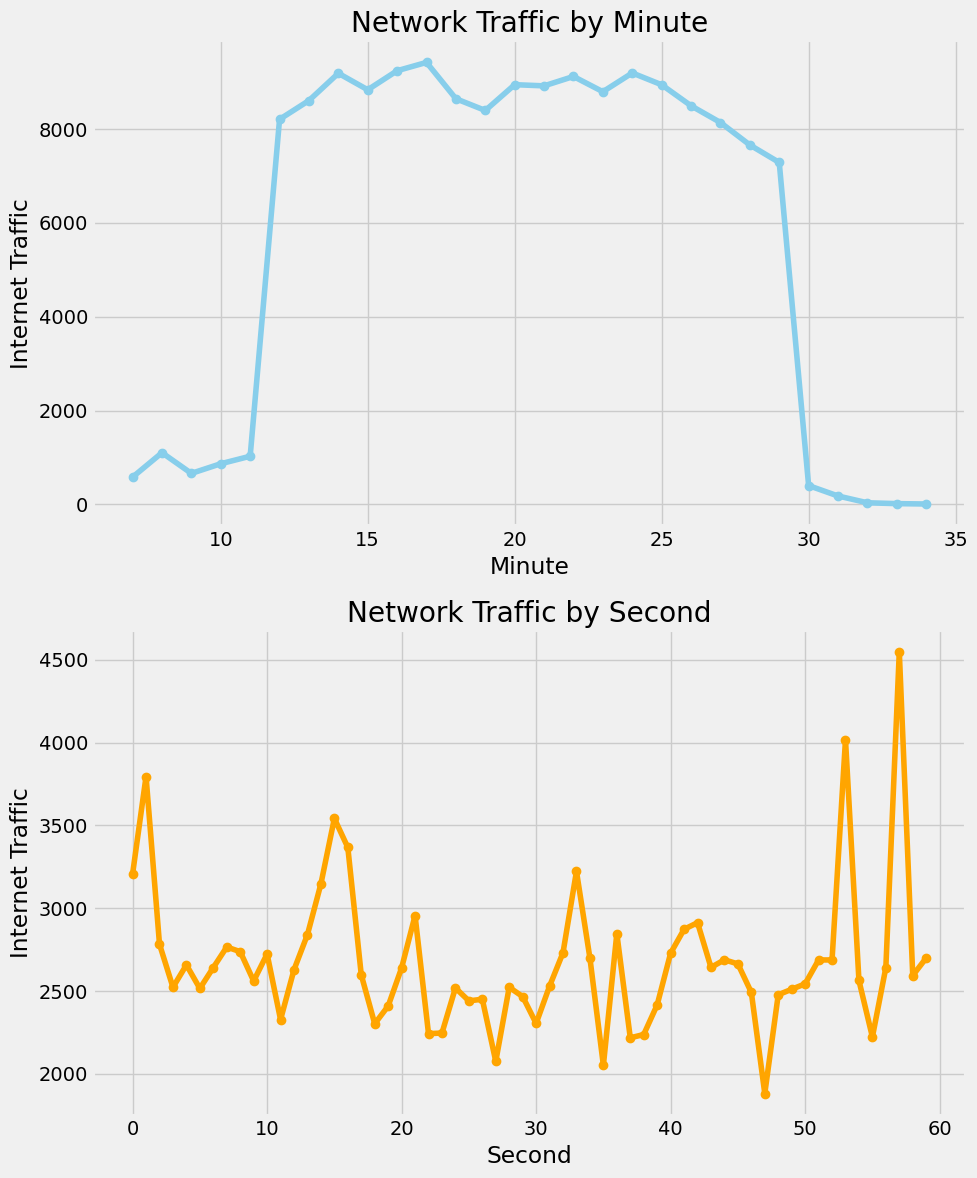

In [63]:
fig, axs = plt.subplots(2, 1, figsize=(10,12))

traffic_by_minute.plot(marker='o', linestyle='-', ax=axs[0], color='skyblue')
axs[0].set_title("Network Traffic by Minute")
axs[0].set_xlabel("Minute")
axs[0].set_ylabel("Internet Traffic")

traffic_by_second.plot(marker='o', linestyle='-', ax=axs[1], color='orange')
axs[1].set_title("Network Traffic by Second")
axs[1].set_xlabel("Second")
axs[1].set_ylabel("Internet Traffic")

plt.tight_layout()
plt.show()

### **B.** *Addresses that download the most data*

In [64]:
download_bytes = df.groupby("source_address")["dst2src_bytes"].sum().sort_values(ascending=False)
top_downloads = download_bytes.head(10)
top_downloads 

source_address
10.1.40.35      3899329404
10.10.40.17     2443807290
10.10.89.10     1113890112
10.1.96.10       889917863
10.10.92.110     502148160
10.1.66.175      325533011
10.1.68.100      247359281
10.10.145.13     131585498
10.10.111.10     106929061
10.1.76.110       63169820
Name: dst2src_bytes, dtype: int64

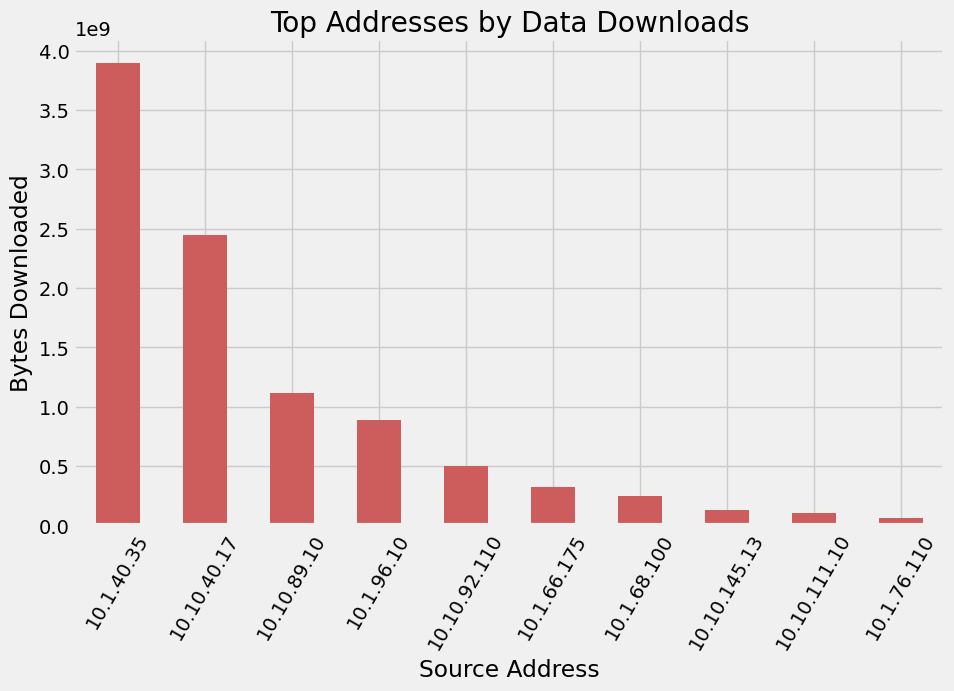

In [65]:
top_downloads.plot(kind='bar', figsize=(10, 6), color='indianred')
plt.title("Top Addresses by Data Downloads")
plt.xlabel("Source Address")
plt.ylabel("Bytes Downloaded")
plt.xticks(rotation=60)
plt.show()

### **C.** *Top Network Traffic Adresses*

In [66]:
# top sources
top_sources = df["source_address"].value_counts().head(10)
print("Top 10 Sources generating most traffic\n", top_sources)

# top destinations 
top_destinations = df["destination_address"].value_counts().head(10)
print("\nTop 10 Destinations receiving most traffic\n", top_destinations)

total_traffic_per_ip = top_sources.add(top_destinations, fill_value=0).sort_values(ascending=False)

Top 10 Sources generating most traffic
 10.1.66.175      29137
10.1.68.100      27432
10.1.68.210       9145
10.10.100.100     8068
10.1.51.60        4669
10.1.60.241       3763
10.1.78.24        2569
10.10.145.13      2285
10.10.145.14      2205
10.212.134.66     2016
Name: source_address, dtype: int64

Top 10 Destinations receiving most traffic
 10.10.100.100    37646
10.10.101.10     14679
10.10.100.101    12306
1.1.1.1           8085
10.1.76.57        5967
10.1.76.120       4994
10.1.76.52        4572
10.10.145.12      4488
10.1.76.110       4382
10.1.40.100       3722
Name: destination_address, dtype: int64


### **D.** *Network Traffic Flow*

In [67]:
# internal-internal, internal-external, or external-internal
df["traffic_flow"] = df.apply(lambda row: "Internal-Internal:" if row["source_type"] == "INTERNAL" and row["destination_type"] == "INTERNAL"
                                                               else ("Internal-External:" if row["source_type"] == "INTERNAL" else "External-Internal:"), axis=1)
traffic_flow_counts = df['traffic_flow'].value_counts()
traffic_flow_counts

Internal-Internal:    145138
Internal-External:     14707
External-Internal:      1138
Name: traffic_flow, dtype: int64

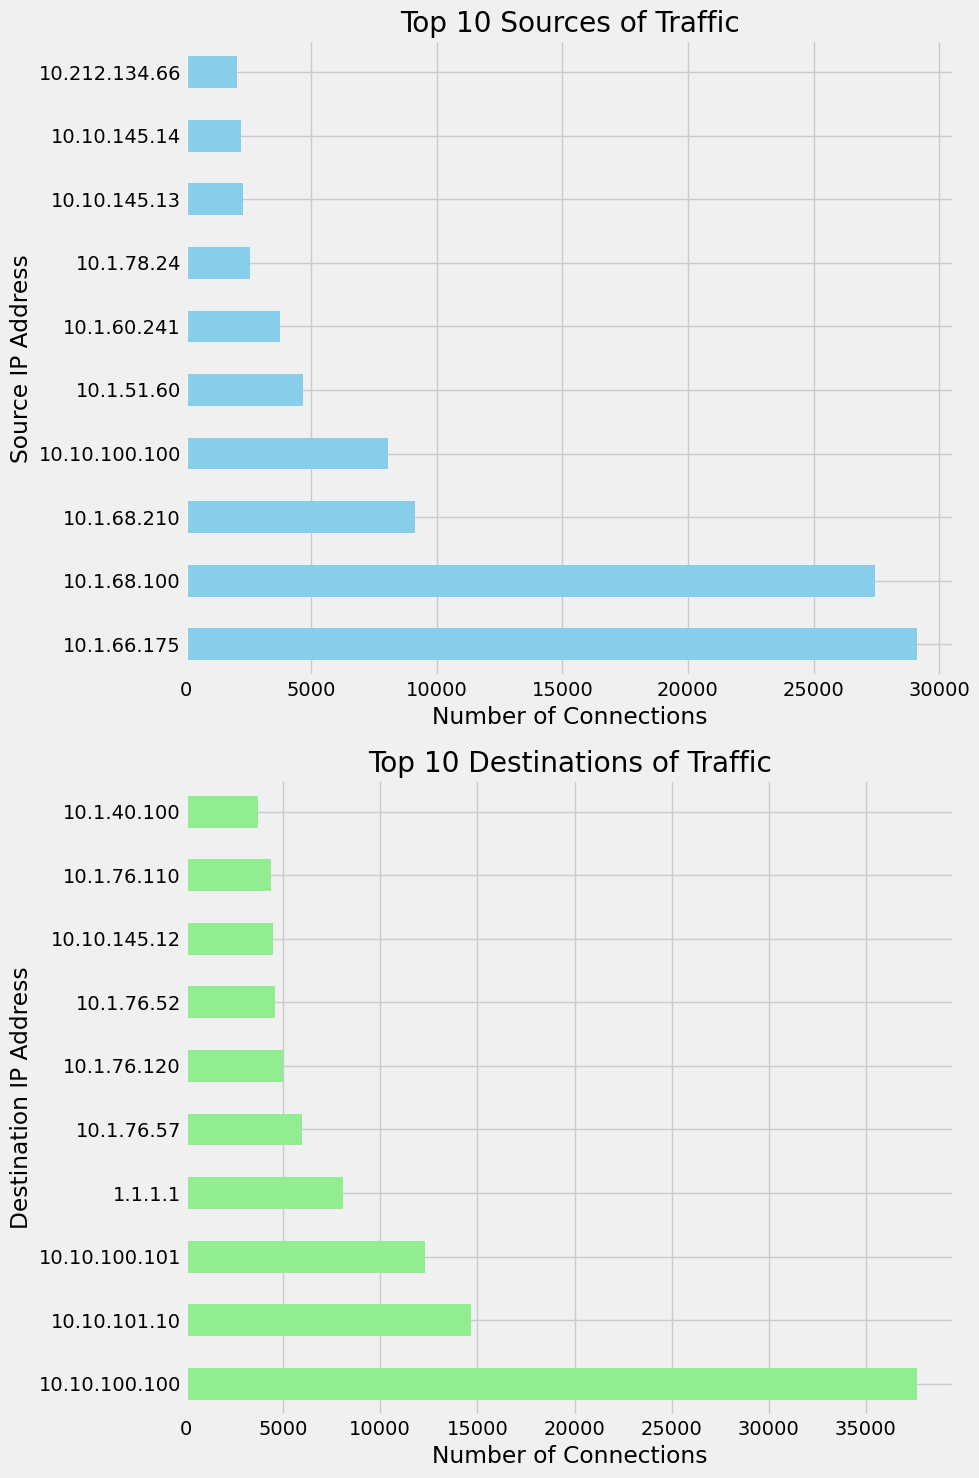

In [68]:
fig, axs = plt.subplots(2, 1, figsize=(10, 15))

top_sources.plot(kind='barh', ax=axs[0], color='skyblue')
axs[0].set_title("Top 10 Sources of Traffic")
axs[0].set_xlabel("Number of Connections")
axs[0].set_ylabel("Source IP Address")

top_destinations.plot(kind='barh', ax=axs[1], color='lightgreen')
axs[1].set_title("Top 10 Destinations of Traffic")
axs[1].set_xlabel("Number of Connections")
axs[1].set_ylabel("Destination IP Address")

plt.tight_layout()
plt.show()

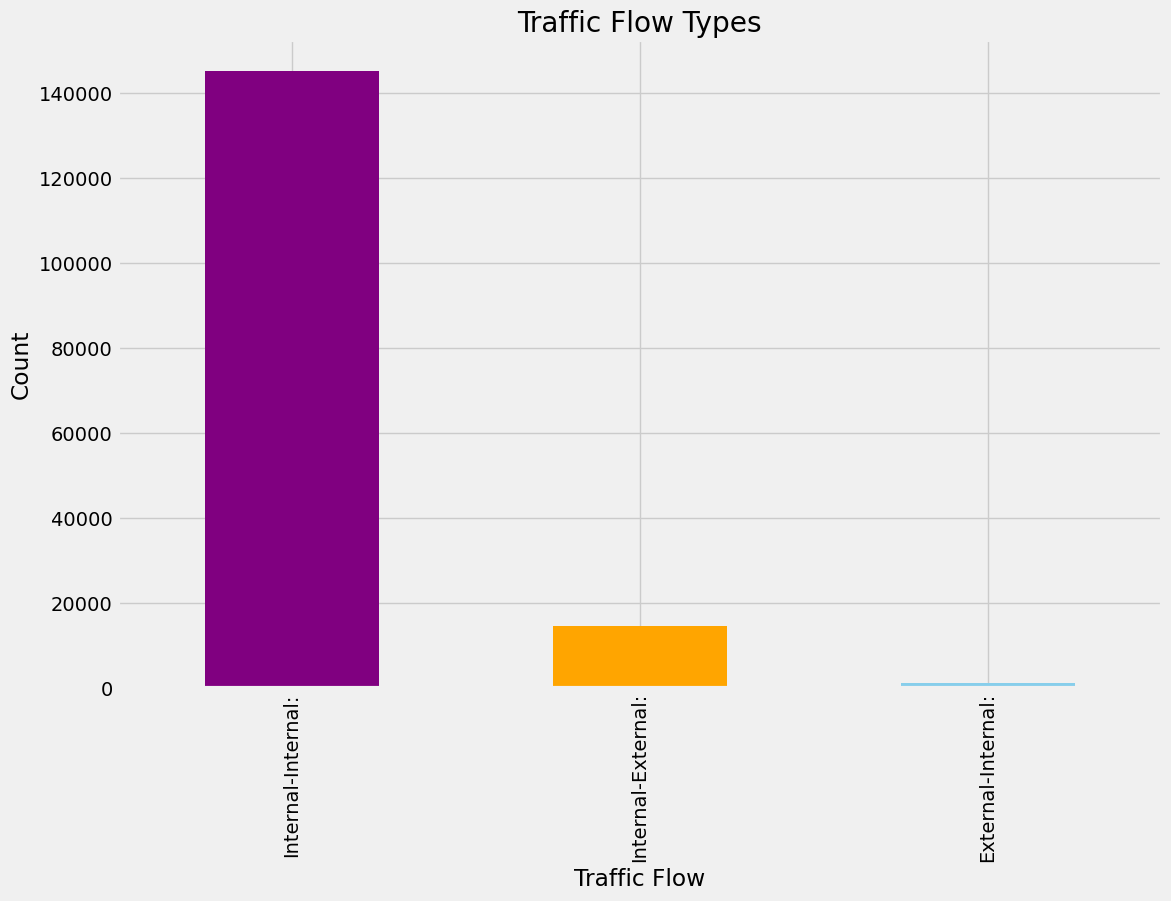

In [71]:
plt.figure(figsize=(12, 8))

traffic_flow_counts.plot(kind='bar', color=['purple', 'orange', 'skyblue'])
plt.title("Traffic Flow Types")
plt.xlabel("Traffic Flow")
plt.ylabel("Count")
plt.show()

## 3. CYBER ATTACK ANALYSIS

In [33]:
# - - - look for Field as given - - -
        # source_address, and destination_address
        # source_port and destination_port
        # protocol
        # application_name, and app_protocol
        # bytes, packets, volume
        # timestamp, time, start_time, end_time
        # error, retry, anomaly, flag

# - - - Cyber Attack Types to be detect - - -
        # Port Scan, 
        # Bruteforce Atacks,
        # ARP Scan, 
        # Exfiltration,
        # Execution

#### **Port Scanning:**

- **Description:** An attacker probes a server, computer, or network to discover open ports. The goal is often to identify open services to exploit vulnerabilities.

- **Related Fields:** Source IP, Destination IP, Destination Port, Timestamps. High frequency of connection attempts to different ports from the same source IP within a short timeframe is a common indicator.

- **Analysis:** Identify potential port scanning activities by analyzing **large numbers of unique destination ports from a single source IP**

In [72]:
port_scan_activities = df.groupby("source_address")["destination_port"].apply(lambda x: len(set(x))).sort_values(ascending = False)
scan_timing = df.groupby("source_address")["event_time"].agg(["min", "max"])
scan_timings = scan_timing.loc[port_scan_activities.index]

top_port_scans = port_scan_activities.head(10)
top_scan_timing = scan_timings.head(10)

port_scan_attack = top_scan_timing.copy()
port_scan_attack.loc[:, "unique_scan_counts"] = top_port_scans.values
port_scan_attack = port_scan_attack.reset_index(drop=False)
port_scan_attack.columns = ["source_address", "first_attempt", "last_attempt", "unique_scan_counts"]
port_scan_attack

,source_address,first_attempt,last_attempt,unique_scan_counts
0,10.1.78.24,14:07:22.688897,14:31:40.114823,1002
1,10.10.111.11,14:09:02.850615,14:30:26.746085,50
2,10.10.100.100,14:08:49.314959,14:34:52.013935,42
3,213.227.139.233,14:12:11.297439,14:29:36.850657,39
4,192.168.2.100,14:07:01.753540,14:29:49.066004,30
5,10.10.111.10,14:09:55.695635,14:33:56.899745,24
6,10.10.107.10,14:12:41.370130,14:29:31.820436,20
7,10.10.100.101,14:12:15.279822,14:30:17.368070,20
8,10.10.10.134,14:07:12.764028,14:31:44.437188,19
9,10.10.10.131,14:07:01.753357,14:30:24.305458,19


In [73]:
top_source_adresses = port_scan_activities.head(10).index

top_scans_df = df[df["source_address"].isin(top_source_adresses)]
targets_by_source = top_scans_df.groupby("source_address")["destination_address"].apply(set)

flattened_list = list(itertools.chain(*targets_by_source.values))
counter = Counter(flattened_list)
top_port_scans_target = counter.most_common(10)
print("Top Port Scan Target Adresses: ")
top_port_scans_target

Top Port Scan Target Adresses: 


[('10.10.130.13', 5),
 ('10.10.111.11', 4),
 ('10.1.40.100', 3),
 ('10.10.107.10', 3),
 ('10.10.100.100', 3),
 ('10.10.100.101', 3),
 ('10.10.10.120', 2),
 ('199.7.91.13', 2),
 ('10.10.100.254', 2),
 ('1.1.1.1', 2)]

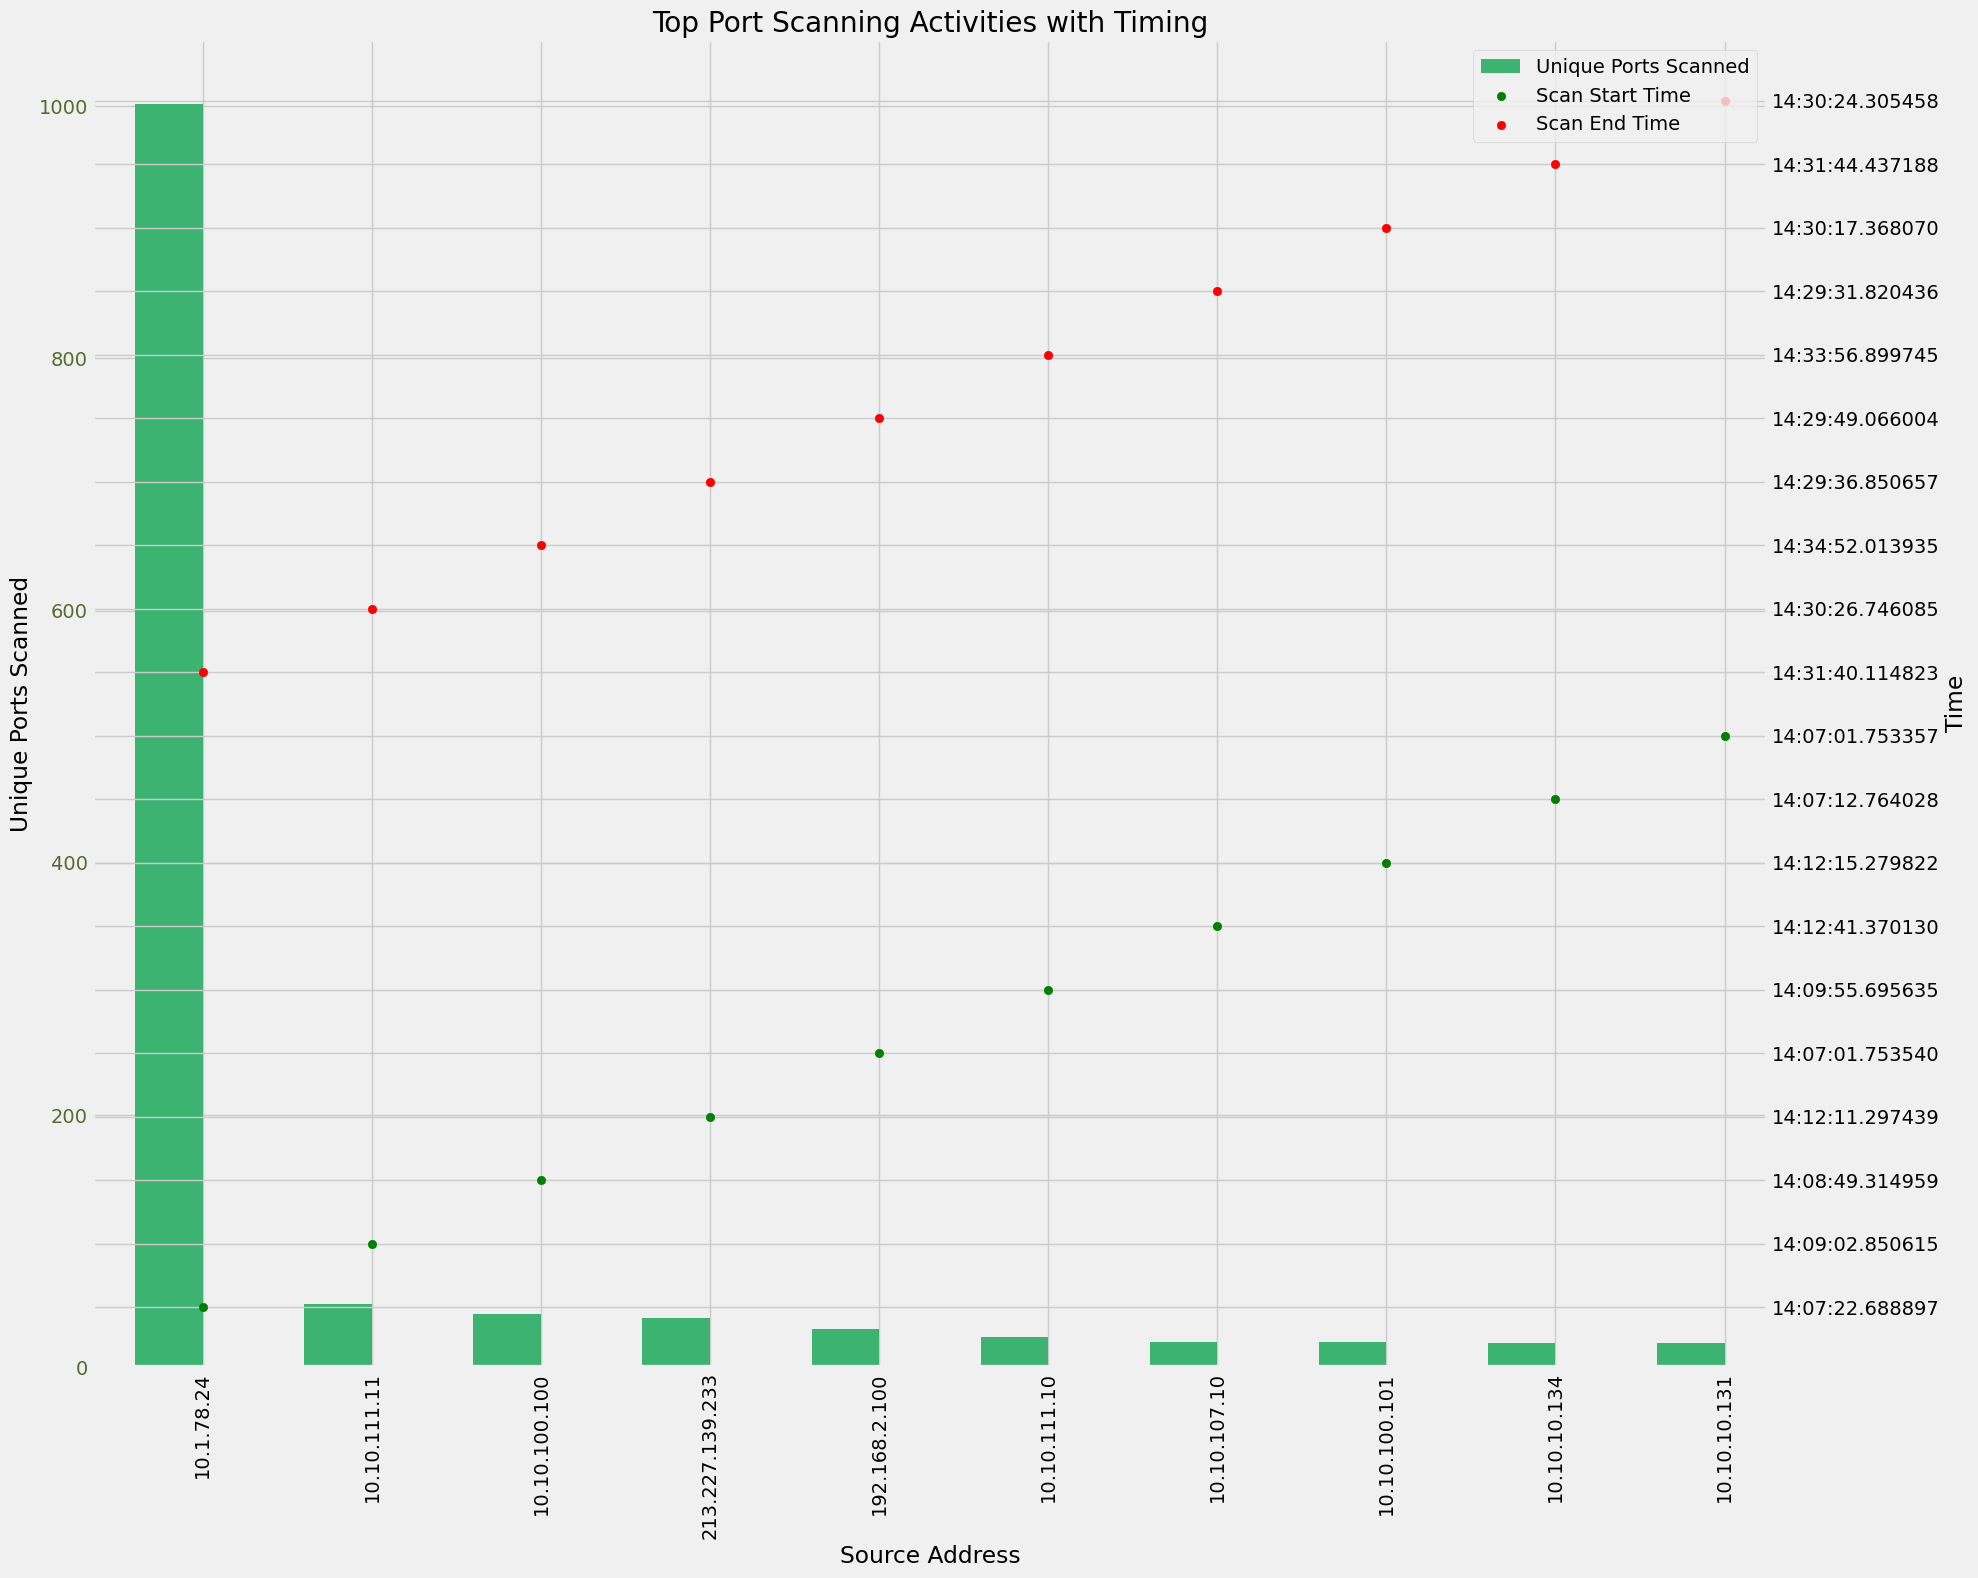

In [74]:
fig, ax1 = plt.subplots(figsize=(20, 16))

top_port_scans.plot(kind='bar', ax=ax1, color='mediumseagreen', position=1, width=0.4, label='Unique Ports Scanned')
ax1.set_xlabel("Source Address")
ax1.set_ylabel("Unique Ports Scanned", color='black')
ax1.tick_params(axis='y', labelcolor='darkolivegreen')

# for the time data
ax2 = ax1.twinx()
ax2.scatter(top_scan_timing.index, top_scan_timing["min"], color='green', label="Scan Start Time")
ax2.scatter(top_scan_timing.index, top_scan_timing["max"], color='red', label="Scan End Time")
ax2.set_ylabel("Time", color='black')
ax2.tick_params(axis='y', labelcolor='black')

fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.title("Top Port Scanning Activities with Timing")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### **Bruteforce:**

- **Description:** An attack method where an **attacker submits many passwords or passphrases with the hope of eventually guessing correctly**. This attack is often targeted against **login interfaces**.

- **Related Fields:** Source IP, Destination IP, Destination Port, **Login Success/Failure, Timestamps.** Repeated login attempts from the same IP or to the same account, especially with rapid succession of failures, can indicate a bruteforce attack.

- **Analysis:** Find source_address, destination_address pairs with high Login Failures.

In [75]:
failed_logins = df[df["login_fail_count"] != 0]

brute_force_attempts = failed_logins.groupby(["source_address", "destination_address"]).agg({
    "login_fail_count": "sum",  # count failed attempts
    "event_time": ["min", "max"]  # time range of attempts
}).reset_index()
brute_force_attempts.columns = ["source_address", "destination_address", "total_login_failures", "first_attempt", "last_attempt"]
top_brute_force_attempts = brute_force_attempts.sort_values('total_login_failures', ascending=False).head(10)
top_brute_force_attempts # 10.1.78.24 login failed 940 times (less than 1 minute)

,source_address,destination_address,total_login_failures,first_attempt,last_attempt
2,10.1.78.24,10.1.78.10,940,14:16:42.123503,14:17:16.111317
37,10.212.134.77,10.1.78.12,20,14:19:00.277670,14:25:19.494568
81,10.61.1.55,10.10.111.11,2,14:12:43.239233,14:13:03.598746
123,185.246.128.133,10.1.71.10,2,14:12:25.661511,14:14:18.969232
28,10.110.10.66,10.10.111.11,2,14:20:16.250486,14:22:38.793099
138,192.168.30.201,10.10.111.11,2,14:16:36.787691,14:17:09.428551
137,192.168.30.184,10.10.111.11,2,14:17:02.873188,14:26:25.754535
36,10.212.134.43,10.10.111.11,2,14:26:16.308361,14:28:41.817974
39,10.29.1.153,10.10.107.10,2,14:20:27.780441,14:22:07.760717
40,10.59.1.32,10.10.111.11,2,14:15:20.187470,14:19:02.535523


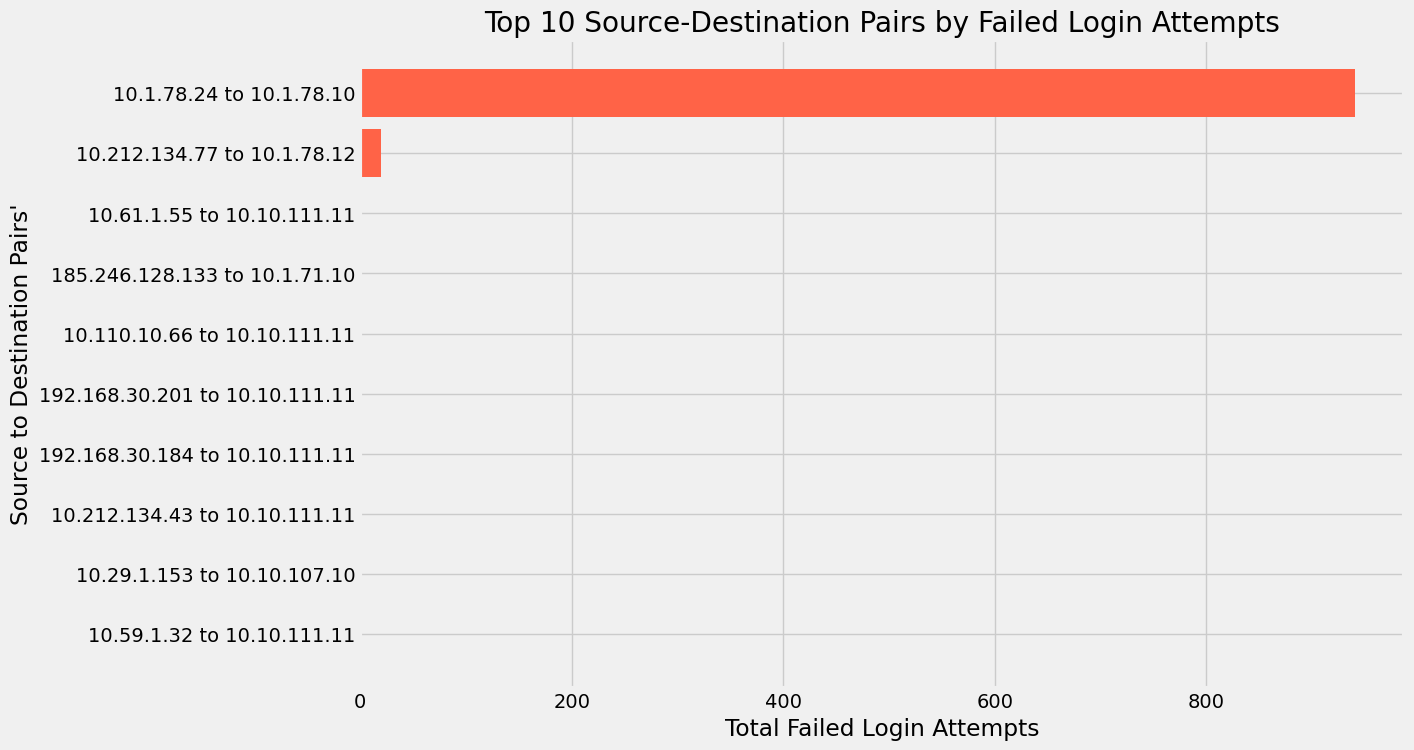

In [76]:
top_brute_force_attempts["source_destination_pair"] = top_brute_force_attempts["source_address"] + " to " + top_brute_force_attempts["destination_address"]

plt.figure(figsize=(12, 8))
plt.barh(top_brute_force_attempts["source_destination_pair"], top_brute_force_attempts["total_login_failures"], color="tomato")
plt.xlabel("Total Failed Login Attempts")
plt.ylabel("Source to Destination Pairs'")
plt.title("Top 10 Source-Destination Pairs by Failed Login Attempts")
plt.gca().invert_yaxis()  
plt.show()

### **Exfiltration:**

- **Description:** Data exfiltration is the unauthorized transfer of data from a computer or network. 
This can occur through various means and is often the objective of cybercriminals after gaining access to a network.

- **Related Fields:** 
Source IP, Destination IP, Destination Port, Bytes Transferred, Timestamps, Protocol. **Unusually large data transfers, especially to external or unusual IP addresses, can be a sign of exfiltration.**

- **Analysis:** Detect unusual large data transfers in the Internal-External network flow.

In [77]:
# can we actually use 'bidirectional_bytes' rather than 'dst2src_bytes'(download)?
correlation = df["bidirectional_bytes"].corr(df["dst2src_bytes"])
assert correlation > 0.70 # to be considered as fields are correlated
print("Corrrelation: ",correlation)

Corrrelation:  0.7248709217146637


In [78]:
internal_external = df[df["traffic_flow"] == "Internal-External:"]

exfiltration_attempts = internal_external.groupby("source_address").agg(
    total_bytes=("bidirectional_bytes", "sum"),
    first_attempt=("event_time", "min"),
    last_attempt=("event_time", "max")
).reset_index()
top_exfiltration_attempts = exfiltration_attempts.sort_values("total_bytes", ascending=False).head(10)
top_exfiltration_attempts

,source_address,total_bytes,first_attempt,last_attempt
54,10.1.96.10,904107831,14:09:55.643484,14:34:23.542182
8,10.1.44.101,23075644,14:12:25.181935,14:27:41.773578
65,10.10.111.10,23029485,14:13:10.321566,14:27:58.660134
33,10.1.68.210,3686821,14:12:00.597913,14:29:59.893543
93,10.29.1.235,3462081,14:16:17.694459,14:29:43.403701
56,10.10.100.100,2924867,14:09:20.654285,14:34:52.013935
18,10.1.66.111,2630376,14:12:24.866167,14:30:16.934919
60,10.10.106.10,369407,14:13:30.346993,14:29:03.423292
27,10.1.66.80,335542,14:12:06.504096,14:29:20.939448
42,10.1.77.10,294897,14:13:25.846725,14:29:02.579504


In [79]:
exfiltration_targets = internal_external[internal_external["source_address"] == "10.1.96.10"].groupby("destination_address")["bidirectional_bytes"].sum().sort_values(ascending=False).head(10)
top_exfiltration_targets = pd.DataFrame(exfiltration_targets).reset_index(drop=False)
top_exfiltration_targets["source_adress"] = "10.1.96.10"
top_exfiltration_targets.columns = ["destination_address","bytes_to_destination","source_adress"]
print("Top Exfiltration Targets (Destination Adresses): ")
top_exfiltration_targets

Top Exfiltration Targets (Destination Adresses): 


,destination_address,bytes_to_destination,source_adress
0,31.145.65.225,259968544,10.1.96.10
1,31.145.65.209,226565755,10.1.96.10
2,31.145.65.161,207563060,10.1.96.10
3,31.145.65.145,140568668,10.1.96.10
4,81.8.63.97,11159523,10.1.96.10
5,199.232.194.2,7400095,10.1.96.10
6,172.64.153.204,5665834,10.1.96.10
7,31.145.65.34,4755792,10.1.96.10
8,157.240.9.52,4011685,10.1.96.10
9,31.145.65.98,3796021,10.1.96.10


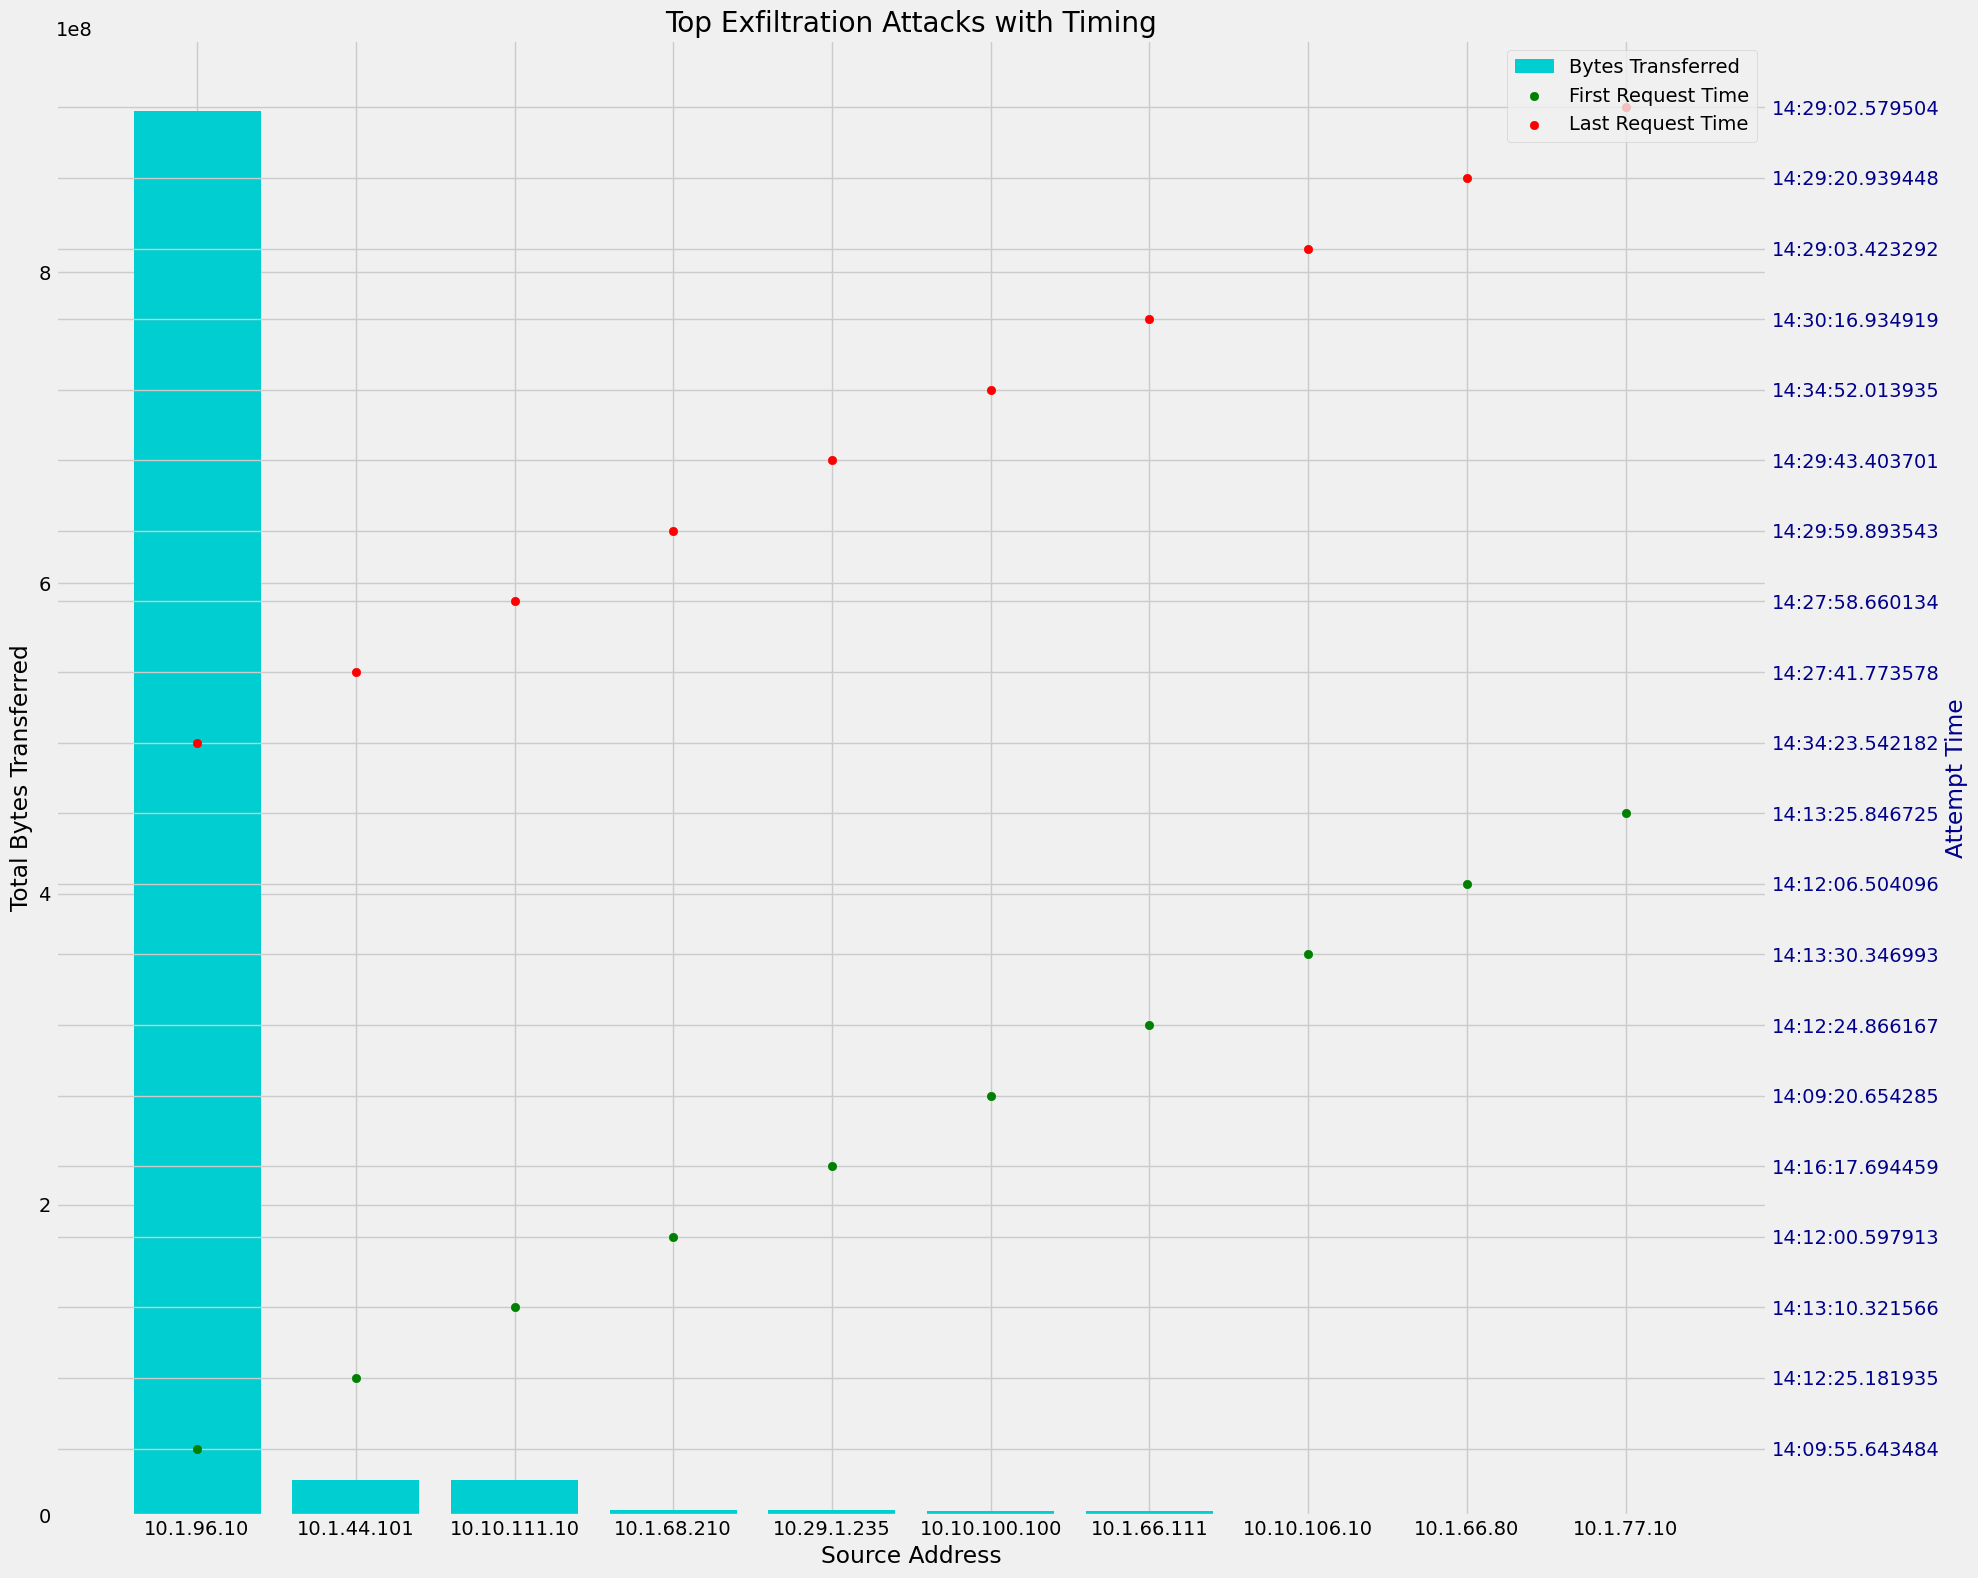

In [80]:
fig, ax1 = plt.subplots(figsize=(20, 16))

ax1.bar(top_exfiltration_attempts["source_address"], top_exfiltration_attempts["total_bytes"], color='darkturquoise', label="Bytes Transferred")
ax1.set_xlabel("Source Address")
ax1.set_ylabel("Total Bytes Transferred", color='black')
ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()
ax2.scatter(top_exfiltration_attempts["source_address"], top_exfiltration_attempts["first_attempt"], color='green', label="First Request Time")
ax2.scatter(top_exfiltration_attempts["source_address"], top_exfiltration_attempts["last_attempt"], color='red', label="Last Request Time")
ax2.set_ylabel("Attempt Time", color='darkblue')
ax2.tick_params(axis='y', labelcolor='darkblue')

fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.title("Top Exfiltration Attacks with Timing")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

 ### **Execution:**

- **Description:** Execution attacks involve the unauthorized execution of code within a system or network, often leading to the compromise of system integrity, data theft, or further exploitation. Repeated access attempts to specific ports that are commonly used for **remote execution (e.g., SSH - port 22, RDP - port 3389, etc.).** Anomalously high traffic volumes from a single source to a single destination, potentially indicating command and control (C&C) communication

- **Related Fields:** Destination IP, Destination Port, Payload, Protocol, Anomalies in packet sizes or intervals. Execution attacks might be indicated by unusual traffic patterns or payloads that contain malicious code.

- **Analysis:** Detect unusual atttempt to open remote ports.

In [81]:
# ports used for remote execution 
# remote_execution_ports = [22, 23, 3389, 445, 5900]  # SSH, Telnet, RDP, SMB, VNC  // https://blog.netwrix.com/2022/08/04/open-port-vulnerabilities-list/
remote_execution_ports = [20, 21, 22, 23, 25, 53, 80, 137, 139, 443, 1433, 1434, 3306, 3389, 445, 5900, 8080, 8443] 
remote_execution_ports_traffic = df[df["destination_port"].isin(remote_execution_ports)]

execution_attempts = remote_execution_ports_traffic.groupby(["source_address", "destination_port"]).agg({
    "event_time": ["min", "max"],
}).reset_index()
execution_attempts["attempt_count"] = remote_execution_ports_traffic.groupby(["source_address", "destination_port"]).size().values

execution_attempts.columns = ["source_address", "destination_port", "first_event_time", "last_event_time", "attempt_count"]
execution_attempts = execution_attempts.sort_values(by = "attempt_count", ascending=False)
poss_execution_attempts = cluster(execution_attempts, "attempt_count") # to determine possible suspect/s

top_execution_attempts = execution_attempts.head(10)
poss_execution_attempts

Cluster Label Counts:
low        1072
normal       16
high          2
extreme       1
Name: cluster, dtype: int64 

Cluster Centers: 
[[  30.37313433]
 [4216.        ]
 [1287.375     ]
 [7941.        ]]


,source_address,destination_port,first_event_time,last_event_time,attempt_count,cluster
192,10.10.100.100,53,14:09:20.654285,14:34:52.013935,7941,extreme
40,10.1.51.60,53,14:09:49.372455,14:31:17.721317,4669,high
47,10.1.60.241,53,14:10:36.607919,14:31:30.810353,3763,high
286,10.10.145.13,3306,14:09:53.753424,14:30:00.755066,2279,normal
288,10.10.145.14,3306,14:12:01.615060,14:30:36.452949,2202,normal
...,...,...,...,...,...,...
686,101.132.143.108,5900,14:21:50.358129,14:21:50.358129,1,low
683,10.83.1.54,80,14:17:30.205589,14:17:30.205589,1,low
681,10.83.1.41,80,14:26:32.400123,14:26:32.400123,1,low
679,10.83.1.39,80,14:16:39.104710,14:16:39.104710,1,low


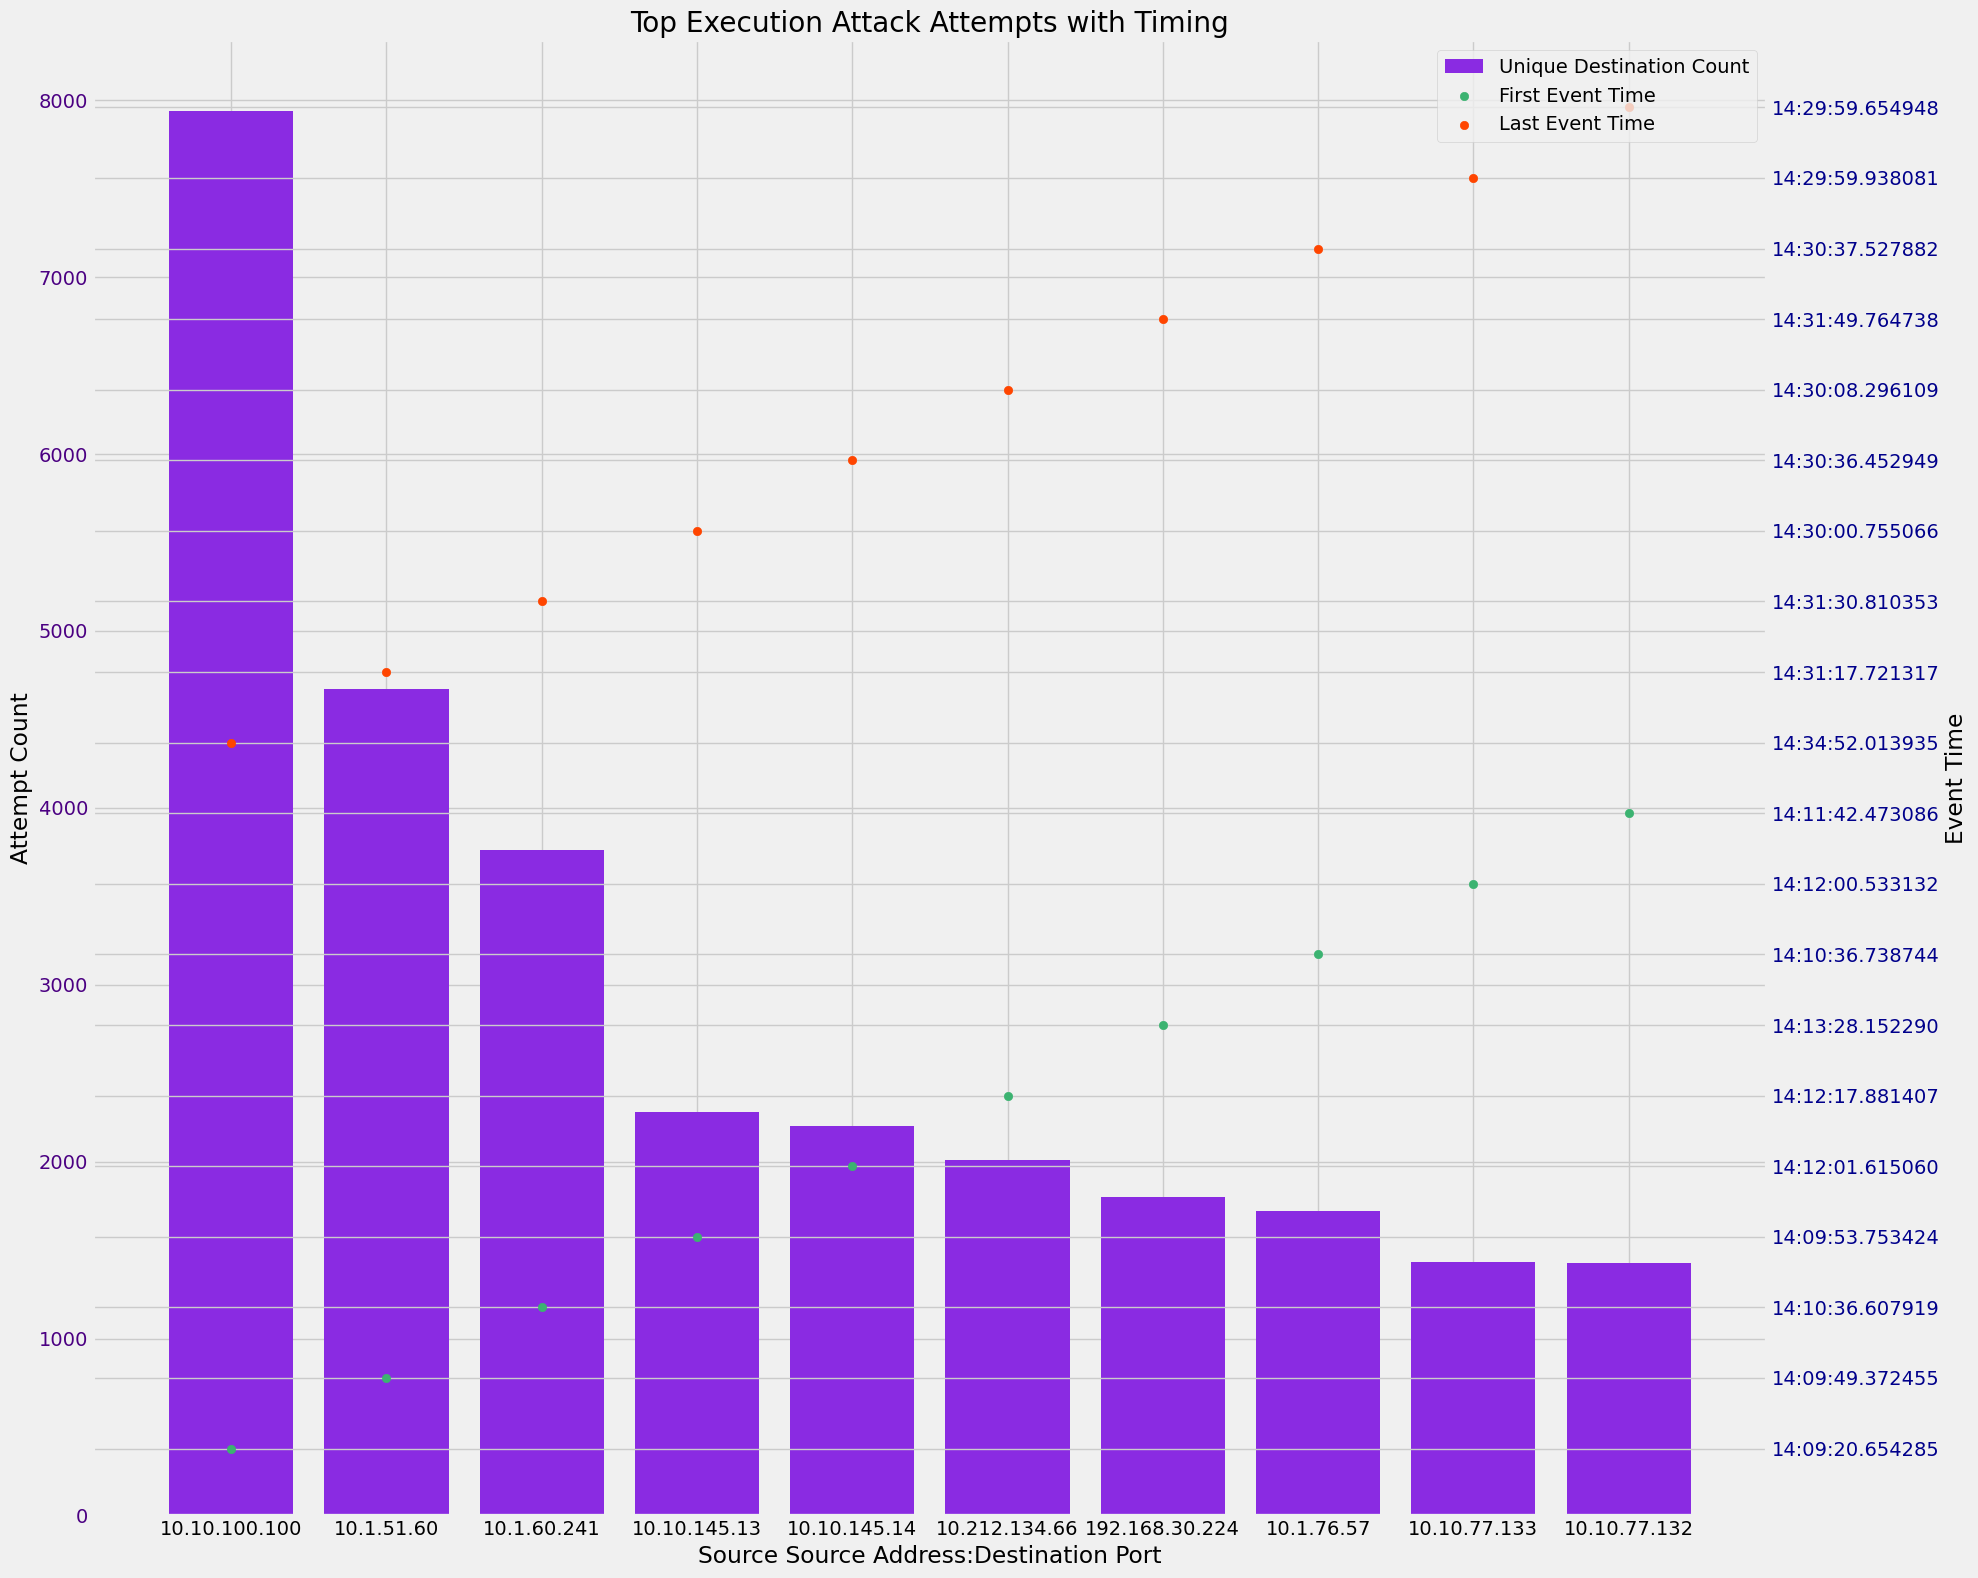

In [84]:
fig, ax1 = plt.subplots(figsize=(20, 16))

ax1.bar(top_execution_attempts["source_address"] + ":" + top_execution_attempts["destination_port"].astype(str), top_execution_attempts["attempt_count"], color='blueviolet', label="Unique Destination Count")
ax1.set_xlabel("Source Source Address:Destination Port")
ax1.set_ylabel("Attempt Count", color='black')
ax1.tick_params(axis='y', labelcolor='indigo')

ax2 = ax1.twinx()
ax2.scatter(top_execution_attempts["source_address"] , top_execution_attempts["first_event_time"], color='mediumseagreen', label="First Event Time")
ax2.scatter(top_execution_attempts["source_address"] , top_execution_attempts["last_event_time"], color='orangered', label="Last Event Time")
ax2.set_ylabel("Event Time", color='black')
ax2.tick_params(axis='y', labelcolor='darkblue')

fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.title("Top Execution Attack Attempts with Timing")
plt.xticks(rotation=180)
plt.tight_layout()
plt.show()

### **ARP Scan:**

- **Description:** ARP (Address Resolution Protocol) poisoning is a technique used to attack an Ethernet network by sending fake ARP messages onto the network. 

- **Indicators:** A high number of **ARP requests (protocol field) from a single source address.** Requests **targeting unique multiple destination addresses** within a short timeframe.

- **Analysis:** Detect frequent ARP request from single source addresses that are targetting multiple destination addresses.

In [85]:
# arp = df[df["protocol_name"] == "ARP"] # 'ARP', 'UDP', 'TCP', 'ICMP', 'IGMP', 'VRRP'
arp_requests = df[df["application_name"] == "ARP-Request"]   # 'ARP-Request', 'ARP-Reply'

arp_scan_candidates = arp_requests.groupby("source_address")["destination_address"].nunique()
timing_analysis = arp_requests.groupby("source_address")["event_time"].agg(["min", "max"])

arp_scan_results = pd.concat([arp_scan_candidates, timing_analysis], axis=1).reset_index()
arp_scan_results.columns = ["source_address", "unique_destinations", "first_request_time", "last_request_time"]

arp_scan_results = arp_scan_results.sort_values("unique_destinations", ascending=False)
top_arp_scans = arp_scan_results.head(10)
top_arp_scans

,source_address,unique_destinations,first_request_time,last_request_time
66,10.1.78.24,256,14:07:22.688897,14:24:22.138949
9,10.1.40.254,16,14:07:53.220008,14:24:53.178171
0,10.1.40.100,8,14:07:12.763593,14:24:54.536850
3,10.1.40.2,7,14:08:04.821380,14:19:06.996994
41,10.1.66.254,7,14:07:53.220333,14:24:53.183548
55,10.1.76.254,6,14:07:53.225828,14:24:53.183758
136,10.10.92.254,6,14:07:53.227604,14:24:53.188675
109,10.10.145.254,5,14:07:54.879116,14:24:53.188866
49,10.1.68.254,4,14:07:53.220393,14:24:53.183588
128,10.10.92.111,3,14:07:01.753822,14:23:04.671381


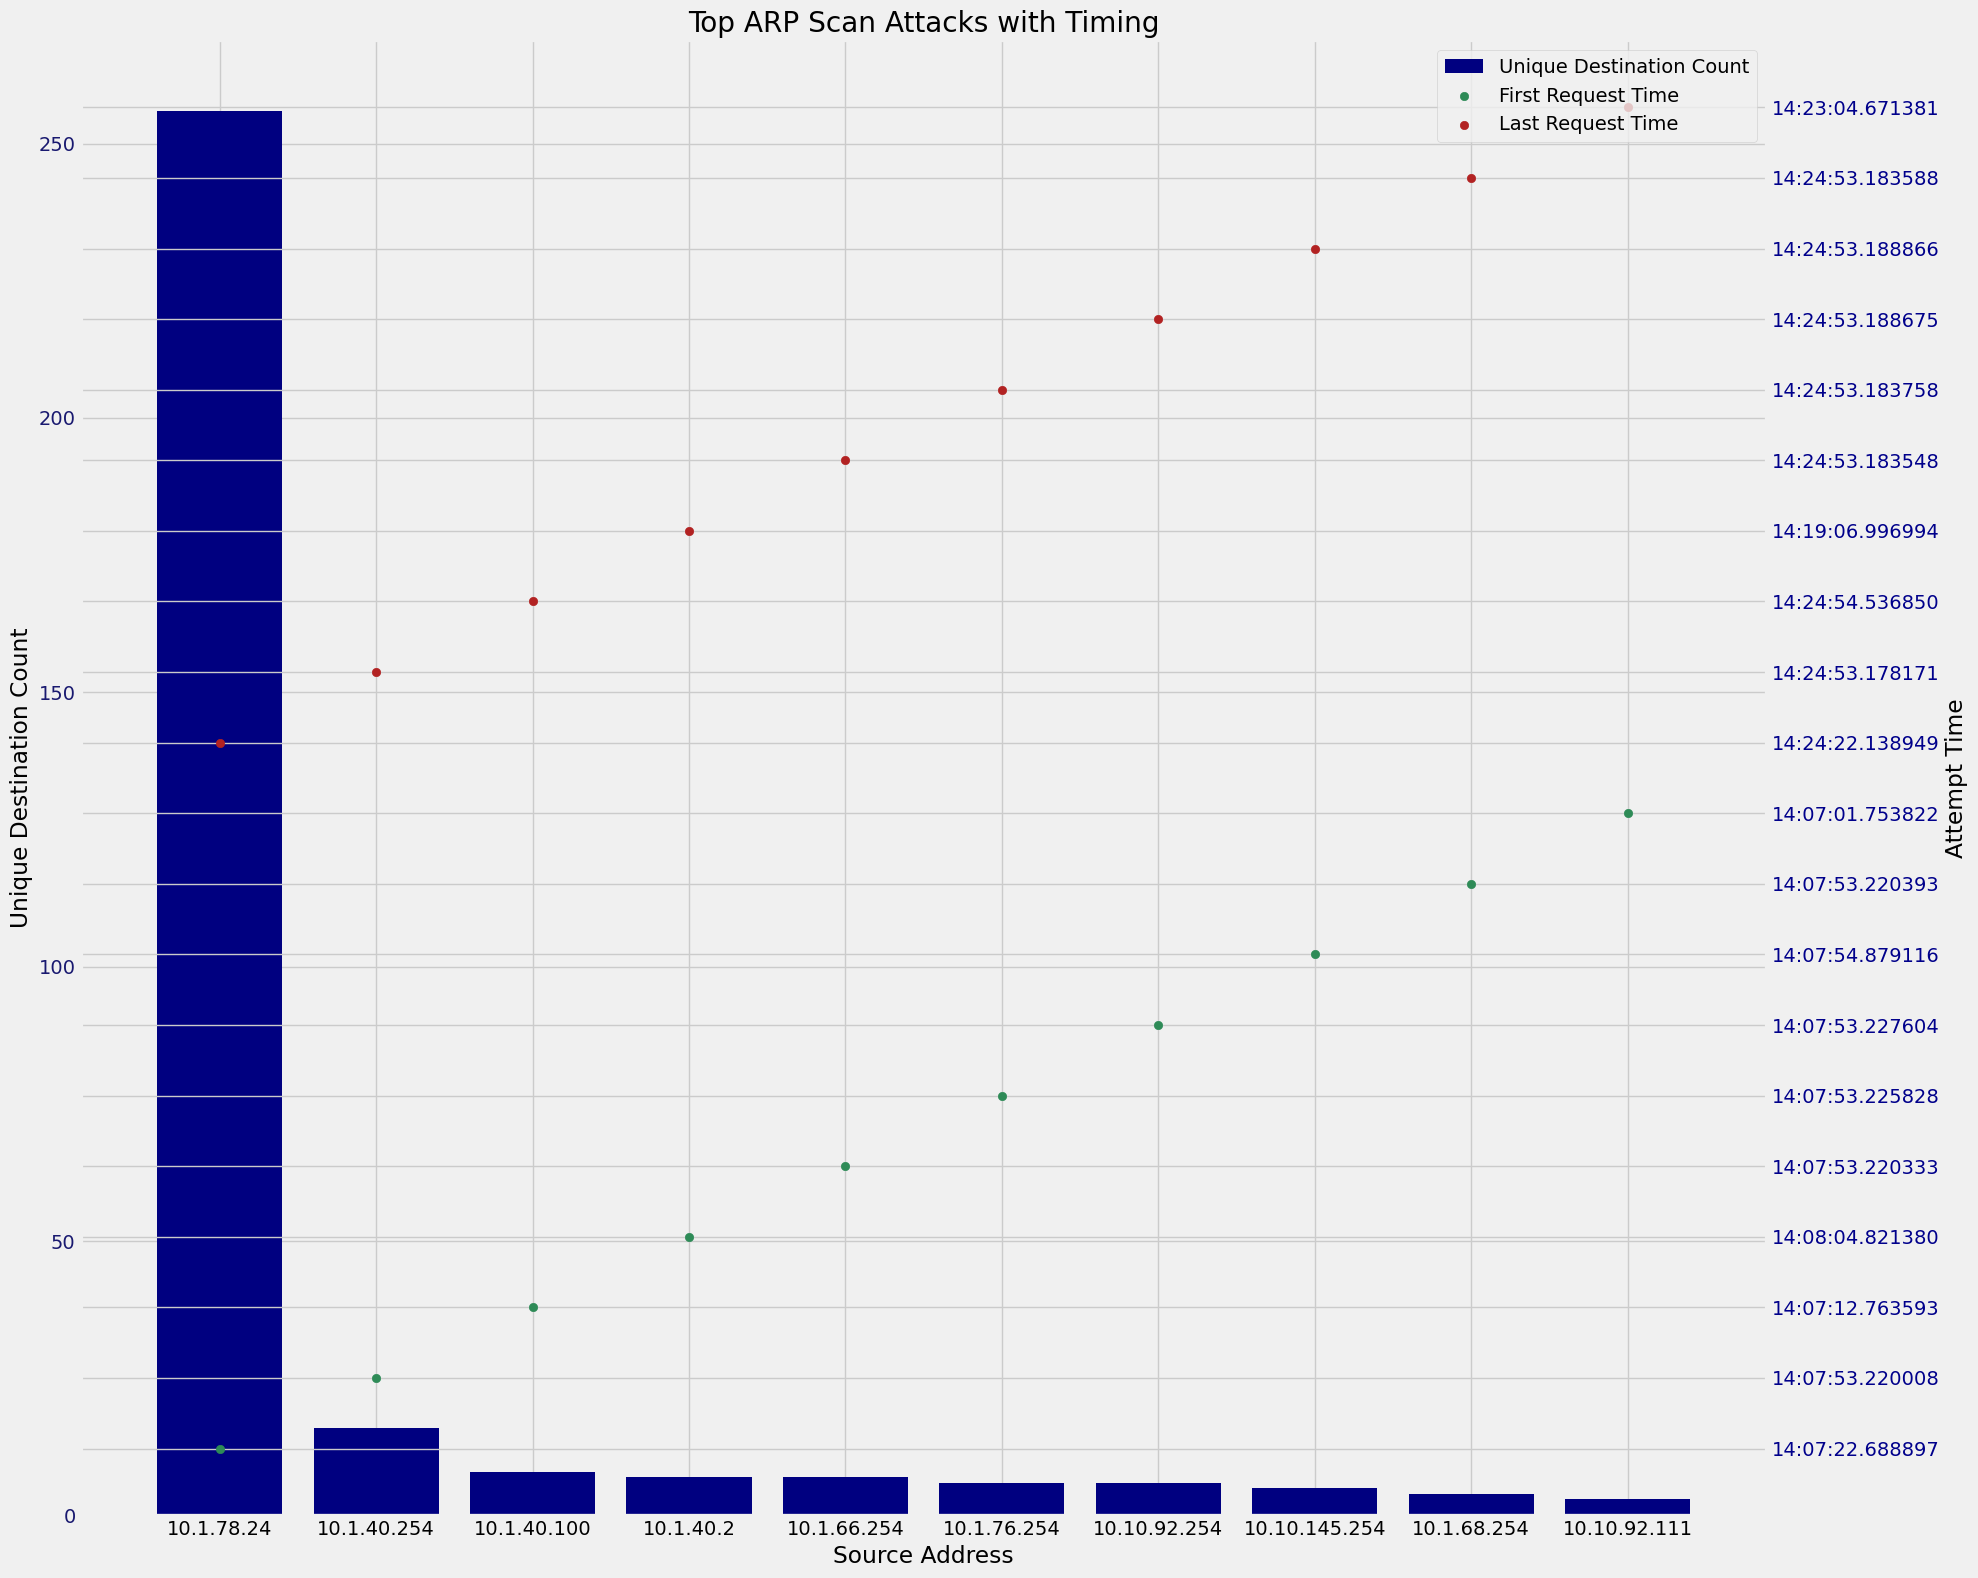

In [86]:
fig, ax1 = plt.subplots(figsize=(20, 16))

ax1.bar(top_arp_scans["source_address"], top_arp_scans["unique_destinations"], color='navy', label="Unique Destination Count")
ax1.set_xlabel("Source Address")
ax1.set_ylabel("Unique Destination Count", color='black')
ax1.tick_params(axis='y', labelcolor='midnightblue')

ax2 = ax1.twinx()
ax2.scatter(top_arp_scans["source_address"], top_arp_scans["first_request_time"], color='seagreen', label="First Request Time")
ax2.scatter(top_arp_scans["source_address"], top_arp_scans["last_request_time"], color='firebrick', label="Last Request Time")
ax2.set_ylabel("Attempt Time", color='black')
ax2.tick_params(axis='y', labelcolor='darkblue')

fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.title("Top ARP Scan Attacks with Timing")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()